# Importaciones

In [1]:
"""Módulo para crear un modelo predictivo de precios de Airbnb en la Comunidad de Madrid."""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import joblib

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.impute import KNNImputer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


# Descargar los datos

In [2]:
#!wget https://data.insideairbnb.com/spain/comunidad-de-madrid/madrid/2024-03-22/data/listings.csv.gz

In [3]:
# Reasoning behind which columns are removed, and which require text processing
columns = [
    'id',                     # Remove - Identifier
    'listing_url',            # Remove - URL with ID at end
    'scrape_id',              # Remove - details of scrape
    'last_scraped',           # Remove - detail of scrape
    'source',                 # Remove - detail of scrape
    'name',                   # Do text processing
    'description',            # Do text processing
    'neighborhood_overview',  # Do text processing
    'picture_url',            # Remove - URl
    'host_id',                # Could learn relation between host and price
    'host_url',               # Remove - redundant with host_id
    'host_name',              # Do text processing
    'host_since',             # Convert to number of months or years
    'host_location',          # Do text processing
    'host_about',             # Do text processing
    'host_response_time', 'host_response_rate',
    'host_acceptance_rate', 'host_is_superhost',
    'host_thumbnail_url',     # Remove
    'host_picture_url',       # Remove
    'host_neighbourhood',     # Do text processing
    'host_listings_count', 'host_total_listings_count',
    'host_verifications',     #
    'host_has_profile_pic', 'host_identity_verified',
    'neighbourhood',          #  Remove - redundant
    'neighbourhood_cleansed', #  Do text processing
    'neighbourhood_group_cleansed',
    'latitude', 'longitude',  # Consider removing, redundant with neighbourhood_cleansed
    'property_type',          #  Do text processing
    'room_type', 'accommodates', 'bathrooms',
    'bathrooms_text',         # Remove - largely redundant
    'bedrooms', 'beds', 'amenities',
    'price',                  # Dependent variable
    'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
    'maximum_minimum_nights', 'minimum_maximum_nights',
    'maximum_maximum_nights', 'minimum_nights_avg_ntm',
    'maximum_nights_avg_ntm',
    'calendar_updated',       # Remove - 0 not null
    'has_availability',
    'availability_30', 'availability_60', 'availability_90',
    'availability_365',
    'calendar_last_scraped',  # Remove - same across all rows
    'number_of_reviews',
    'number_of_reviews_ltm', 'number_of_reviews_l30d',
    'first_review', 'last_review',  # Convert to days ago
    'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location',
    'review_scores_value',
    'license',                # Remove
    'instant_bookable',
    'calculated_host_listings_count',
    'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms', 'reviews_per_month'
]

data_types = {
    'price': pd.StringDtype(),
    'host_response_time': pd.StringDtype(),
    'host_response_rate': pd.StringDtype(),
    'host_acceptance_rate': pd.StringDtype(),
    'host_is_superhost': pd.StringDtype(),
    'host_has_profile_pic': pd.StringDtype(),
    'host_identity_verified': pd.StringDtype(),
    'room_type': pd.StringDtype(),
    'has_availability': pd.StringDtype(),
    'instant_bookable': pd.StringDtype(),
    'name': pd.StringDtype(),
    'description': pd.StringDtype(),
    'neighborhood_overview': pd.StringDtype(),
    'host_name': pd.StringDtype(),
    'host_location': pd.StringDtype(),
    'host_about': pd.StringDtype(),
    'host_neighbourhood': pd.StringDtype(),
    'neighbourhood_cleansed': pd.StringDtype(),
    'neighbourhood_group_cleansed': pd.StringDtype(),
    'property_type': pd.StringDtype(),
    'host_verifications': pd.StringDtype(),
    'amenities': pd.StringDtype(),
}

# Cargar los datos y crear subconjuntos

In [4]:
parse_dates = ['host_since','first_review','last_review']

data = pd.read_csv('listings.csv.gz', parse_dates=parse_dates, dtype=data_types)

# Select only data where there exists a price
data = data[data['price'].notnull()]

# Verify there are no rows with null in the price column
print(f"Nulls present in price column: {data['price'].isnull().values.any()}")

data.shape

Nulls present in price column: False


(20688, 75)

The following columns are selected as being columns of interest. The columns that are not selected are pertaining to the data scraping. It is believed that they would only add noise to the data as it does not reflect the airbnb listings.

In [5]:
cols_of_interest = [
    'price', 'host_id', 'host_since', 'host_response_time', 'host_response_rate',
    'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
    'host_total_listings_count', 'host_verifications', 'host_has_profile_pic',
    'host_identity_verified', 'latitude', 'longitude', 'room_type', 'accommodates',
    'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights',
    'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights',
    'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
    'has_availability', 'availability_30', 'availability_60', 'availability_90',
    'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
    'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
    'review_scores_location', 'review_scores_value', 'instant_bookable',
    'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms',
    'reviews_per_month'
                   ]

The following are selected for text processing. If there is time to add NLP to the data, these columns will be used for that.

In [6]:
# Columns to that require text processing
cols_text = [
    'name', 'description', 'neighborhood_overview', 'host_name',
    'host_location', 'host_about', 'host_neighbourhood', 'neighbourhood_cleansed',
    'neighbourhood_group_cleansed', 'property_type', 'amenities'
            ]

In [7]:
# Create data subsets
data_numerical = data[cols_of_interest]
data_text = data[cols_text]

data_numerical.shape, data_text.shape

((20688, 50), (20688, 11))

# Ingeniería de Características

In [8]:
pd.options.mode.copy_on_write = True

## Cleaning numerical columns

### Clean price

In [9]:
# Strip $ and comma, and cast as numeric
data_numerical['price'] =  data_numerical['price'].replace({"[\$,)]":"",",":""}, regex=True).apply(pd.to_numeric)
y = data_numerical['price']
data_numerical = data_numerical.drop(['price'], axis=1)

### Calculate date columns as years

In [10]:
# Calculate years hosting
data_numerical['host_since_year'] = data_numerical['host_since'].apply(lambda x: x.year)
data_numerical['host_years'] = data_numerical['host_since_year'].apply(lambda x: 2024.0 - x)
data_numerical = data_numerical.drop(['host_since', 'host_since_year'], axis=1)

# Calculate years since first review
data_numerical['first_review_year'] = data_numerical['first_review'].apply(lambda x: x.year)
data_numerical['first_review_age'] = data_numerical['first_review_year'].apply(lambda x: 2024.0 - x)
data_numerical = data_numerical.drop(['first_review', 'first_review_year'], axis=1)

# Calculate years since last review
data_numerical['last_review_year'] = data_numerical['last_review'].apply(lambda x: x.year)
data_numerical['last_review_age'] = data_numerical['last_review_year'].apply(lambda x: 2024.0 - x)
data_numerical = data_numerical.drop(['last_review', 'last_review_year'], axis=1)

### Convert t/f columns to 1/0

In [11]:
# Change t f columns to 1 and 0
columns_t_f = ['host_is_superhost','host_has_profile_pic', 'host_identity_verified','has_availability','instant_bookable']
t_f = {'t':'1', 'f':'0'}

for col in columns_t_f:
    data_numerical[col] = data_numerical[col].replace(t_f)

data_numerical[columns_t_f] = data_numerical[columns_t_f].apply(pd.to_numeric)

### Convert rate columns to numerical

In [12]:
# Strip % and convert int
columns_percent = ['host_response_rate','host_acceptance_rate']

for col in columns_percent:
    data_numerical[col] = data_numerical[col].str.replace('%', '').apply(pd.to_numeric)

### Transform nominal variables using one hot encoding
One hot encoding is a common processing technique of nominal variables.

In [13]:
# host_verifications column
# Clean string
data_numerical['host_verifications'] = data_numerical['host_verifications'].str.replace(r"[\'\[\]]", "", regex=True)
data_numerical['host_verifications'] = data_numerical['host_verifications'].str.replace(" ", "")

verification_cols = ['email_verified', 'phone_verified','work_email_verified']

# Expand columns
data_numerical[verification_cols] = data_numerical['host_verifications'].str.split(',', expand=True)

# Convert to 1 and 0
data_numerical[verification_cols] = data_numerical[verification_cols].notnull().astype(float)

# Drop original column
data_numerical = data_numerical.drop(['host_verifications'], axis=1)

In [14]:
# Transform further nominal columns using one hot encoding
columns_categorical = ['host_response_time', 'room_type']

data_numerical = pd.get_dummies(data_numerical, columns=columns_categorical)

## Text data

In [15]:
data_text.head(2)

,name,description,neighborhood_overview,host_name,host_location,host_about,host_neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,amenities
0,Bright and airy room,We have a quiet and sunny room with a good vie...,We live in a leafy neighbourhood with plenty o...,Abdel,"Madrid, Spain",EN-ES-FR EN Hi everybody: I'm Abdel. I'm spa...,Aluche,Cármenes,Latina,Private room in rental unit,"[""Fire extinguisher"", ""Extra pillows and blank..."
1,Gran Via Studio Madrid,"Studio located 50 meters from Gran Via, next t...","The area is next to the Gran Via, so people li...",Alvaro,<NA>,<NA>,<NA>,Universidad,Centro,Entire rental unit,"[""Luggage dropoff allowed"", ""Fire extinguisher..."


In [16]:
data_text.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20688 entries, 0 to 26023
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   name                          20688 non-null  string
 1   description                   20124 non-null  string
 2   neighborhood_overview         10509 non-null  string
 3   host_name                     20688 non-null  string
 4   host_location                 14034 non-null  string
 5   host_about                    10278 non-null  string
 6   host_neighbourhood            7461 non-null   string
 7   neighbourhood_cleansed        20688 non-null  string
 8   neighbourhood_group_cleansed  20688 non-null  string
 9   property_type                 20688 non-null  string
 10  amenities                     20688 non-null  string
dtypes: string(11)
memory usage: 1.9 MB


In [17]:
# Clean amenities column
data_text['amenities'] = data_text['amenities'].str.replace(r"[\'\[\]]", "", regex=True)
data_text['amenities'] = data_text['amenities'].str.replace("\"", "", regex=True)

# lowercase applied to all columns
for col in data_text.columns:
    data_text[col] = data_text[col].str.lower()

# Fill na with empty string
data_text = data_text.fillna("")
print(f"Number of nulls left in the data {data_text.isnull().any().sum()}")
print(data_text.shape)

Number of nulls left in the data 0
(20688, 11)


# Data exploration

In [18]:
data_numerical.describe().round(2)

,host_id,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,...,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_years,first_review_age,last_review_age,email_verified,phone_verified,work_email_verified
count,2.068800e+04,19208.00,19889.00,20578.0,20688.00,20688.00,20688.0,20688.0,20688.00,20688.00,...,20688.00,20688.00,20688.00,17020.00,20688.00,17020.00,17020.00,20688.0,20688.00,20688.00
mean,2.418827e+08,93.43,86.22,0.27,41.17,51.99,0.97,0.98,40.42,-3.69,...,27.95,2.01,0.22,2.02,5.87,3.00,0.38,1.0,0.91,0.12
std,1.941275e+08,19.02,25.52,0.44,100.21,146.98,0.16,0.13,0.02,0.03,...,63.94,6.22,2.15,1.92,3.56,2.73,0.89,0.0,0.29,0.32
min,1.745300e+04,0.00,0.00,0.0,1.00,1.00,0.0,0.0,40.33,-3.83,...,0.00,0.00,0.00,0.01,0.00,0.00,0.00,1.0,0.00,0.00
25%,4.560215e+07,98.00,88.00,0.0,1.00,2.00,1.0,1.0,40.41,-3.71,...,1.00,0.00,0.00,0.59,3.00,1.00,0.00,1.0,1.00,0.00
50%,2.162034e+08,100.00,99.00,0.0,4.00,6.00,1.0,1.0,40.42,-3.70,...,2.00,0.00,0.00,1.48,6.00,2.00,0.00,1.0,1.00,0.00
75%,4.367836e+08,100.00,100.00,1.0,26.00,32.00,1.0,1.0,40.43,-3.69,...,15.00,1.00,0.00,2.87,9.00,5.00,1.00,1.0,1.00,0.00
max,5.679689e+08,100.00,100.00,1.0,2257.00,5669.00,1.0,1.0,40.54,-3.55,...,300.00,72.00,38.00,28.73,15.00,14.00,12.00,1.0,1.00,1.00


## Final data transformations

In [19]:
data_numerical.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20688 entries, 0 to 26023
Data columns (total 57 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   host_id                                       20688 non-null  int64  
 1   host_response_rate                            19208 non-null  float64
 2   host_acceptance_rate                          19889 non-null  float64
 3   host_is_superhost                             20578 non-null  Int64  
 4   host_listings_count                           20688 non-null  float64
 5   host_total_listings_count                     20688 non-null  float64
 6   host_has_profile_pic                          20688 non-null  Int64  
 7   host_identity_verified                        20688 non-null  Int64  
 8   latitude                                      20688 non-null  float64
 9   longitude                                     20688 non-null  floa

In [20]:
data_numerical.head()

,host_id,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,...,phone_verified,work_email_verified,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,83531,NaN,NaN,0,2.0,2.0,1,1,40.40381,-3.74130,...,1.0,0.0,False,False,False,False,False,False,True,False
1,346366726,NaN,NaN,0,1.0,1.0,1,1,40.42183,-3.70529,...,1.0,0.0,False,False,False,False,True,False,False,False
2,1004721,100.0,100.0,0,2.0,4.0,1,1,40.41520,-3.69668,...,1.0,0.0,False,True,False,False,True,False,False,False
4,1008659,100.0,100.0,1,5.0,6.0,1,1,40.42116,-3.70384,...,1.0,1.0,False,False,False,True,True,False,False,False
5,1031664,100.0,100.0,0,1.0,2.0,1,1,40.41126,-3.70347,...,1.0,0.0,False,True,False,False,False,False,True,False


### Investigating nulls in the data


In [21]:
num_columns_with_nulls = data_numerical.isnull().any().sum()
print(f"Out of {len(data_numerical.columns)} there are {num_columns_with_nulls} columns with nulls")

# Calculate the percentage of nulls in each column
null_percentages = data_numerical.isnull().mean() * 100

# Find the max percentage of nulls
max_null_percentage = null_percentages.max()
column_with_max_nulls = null_percentages.idxmax()

print(f"Column with the largest percentage of nulls: {column_with_max_nulls}")
print(f"Largest percentage of nulls in a single column: {max_null_percentage:.2f}%")

Out of 57 there are 17 columns with nulls
Column with the largest percentage of nulls: review_scores_cleanliness
Largest percentage of nulls in a single column: 17.82%


As there are not a large percentage of nulls in the data, it feels safe to fill in these values using KNN Inputer. This method for filling values should add less noise to the data, as values are imputed based on the mean value from the data points closest in the dataset.

In [22]:
rows_with_null = []

for col in data_numerical.columns:
    if data_numerical[col].isnull().values.any():
        rows_with_null.append(col)
        data_numerical[col] = data_numerical[col].astype(float)

# Fill Nulls using KNN Imputer
imputer = KNNImputer()
data_numerical = pd.DataFrame(imputer.fit_transform(data_numerical),
                              columns=data_numerical.columns)

print(data_numerical.isnull().values.any())

False


In [24]:
# Normalize data using min-max normalization
scaler = MinMaxScaler()
normalized_numerical_data = pd.DataFrame(scaler.fit_transform(data_numerical),
                                         columns=data_numerical.columns)

# Verify no nulls exist
normalized_numerical_data.isnull().values.any()

False

# Model Training

Two models were chosen to test for this task: Random Forest Regressor and Gradient Boosting Regressor. A regressor was necessary as this is a regression task. Furthermore, both models are natively adept at handling sparce data. With the data containing a number of categorical variables that required onehot encoding, the data was quite sparce.

As this is a regression task, MSE RMSE, and MAE are appropriate evaluation metrics.

- MSE is the average of the squared differences between the actual and predicted values. An MSE close to 0 is better.
- RMSE is the square root of MSE, and can be easier to interpret.

In [25]:
def evaluate(model, test_features, y_true):
    """
    Function to print model performance metrics.
    """
    pred = model.predict(test_features)
    mse =  metrics.mean_squared_error(y_true, pred)
    mae = metrics.mean_absolute_error(y_true, pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - pred) / np.abs(y_true)))

    print('-----Model Performance-----')
    print(f"Mean Absolute Error (MAE): {round(mae, 2)}")
    print(f"Mean Squared Error (MSE): {round(mse, 2)}")
    print(f"Root Mean Squared Error (RMSE): {round(rmse, 2)}")
    print(f"Mean Absolute Percentage Error (MAPE): {round(mape * 100, 2)}")
    print(f"Accuracy: {round(100*(1 - mape), 2)}")

    return

In [97]:
# Ensure text data is string type
data_text = data_text.astype(str)

cols = data_text.columns.tolist()
for col in data_numerical.columns:
    cols.append(col)

# Rejoin text and numerical data
X_data = pd.concat([data_text.reset_index(drop=True),
                    normalized_numerical_data.reset_index(drop=True),],
                    axis=1, ignore_index=True)

# Assign column names
X_data.columns = cols

X_data.to_csv('X_data.csv')

print(X_data.isnull().values.any())
X_data.head(2)


False


,name,description,neighborhood_overview,host_name,host_location,host_about,host_neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,...,phone_verified,work_email_verified,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,bright and airy room,we have a quiet and sunny room with a good vie...,we live in a leafy neighbourhood with plenty o...,abdel,"madrid, spain",en-es-fr\r\nen\r\nhi everybody: i'm abdel. i'm...,aluche,cármenes,latina,private room in rental unit,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,gran via studio madrid,"studio located 50 meters from gran via, next t...","the area is next to the gran via, so people li...",alvaro,,,,universidad,centro,entire rental unit,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Training model on text and numerical data

In [104]:
# Load data
X_data = pd.read_csv('X_data.csv', index_col=0)
X_data.head(2)

,name,description,neighborhood_overview,host_name,host_location,host_about,host_neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,...,phone_verified,work_email_verified,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,bright and airy room,we have a quiet and sunny room with a good vie...,we live in a leafy neighbourhood with plenty o...,abdel,"madrid, spain",en-es-fr\r\nen\r\nhi everybody: i'm abdel. i'm...,aluche,cármenes,latina,private room in rental unit,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,gran via studio madrid,"studio located 50 meters from gran via, next t...","the area is next to the gran via, so people li...",alvaro,NaN,NaN,NaN,universidad,centro,entire rental unit,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [106]:
# When I fillna with empty string, the model wont train
X_data[data_text.columns] = X_data[data_text.columns].fillna(" ")

X_data[data_text.columns].isnull().values.any()
X_data.head(2)


,name,description,neighborhood_overview,host_name,host_location,host_about,host_neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,...,phone_verified,work_email_verified,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,bright and airy room,we have a quiet and sunny room with a good vie...,we live in a leafy neighbourhood with plenty o...,abdel,"madrid, spain",en-es-fr\r\nen\r\nhi everybody: i'm abdel. i'm...,aluche,cármenes,latina,private room in rental unit,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,gran via studio madrid,"studio located 50 meters from gran via, next t...","the area is next to the gran via, so people li...",alvaro,,,,universidad,centro,entire rental unit,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [108]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y, test_size=0.33, random_state=42
)

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('text_' + str(i), TfidfVectorizer(ngram_range=(1, 2)), col) for i, col in enumerate(data_text.columns)
    ]
)

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Fit the pipeline
clf = pipe.fit(X_train, y_train)

# Save model
joblib.dump(clf, 'models/base_model_all_data.pkl', compress=True)

# Predict
#y_pred = clf.predict(X_test)

In [ ]:
base_model = joblib.load('models/base_model_all_data.pkl')

evaluate(clf, X_test, y_test)

## Training models on numerical data alone


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    normalized_numerical_data, y, test_size=0.33, random_state=42)

## Random Forest Regressor

### Baseline Results

In [ ]:
# Baseline
base_model = RandomForestRegressor(random_state=42)
base_model.fit(X_train, y_train)

# Save model
joblib.dump(base_model, 'models/base_model.pkl', compress=True)

In [358]:
base_model = joblib.load('models/base_model.pkl')

evaluate(base_model, X_test, y_test)

-----Model Performance-----
Mean Absolute Error (MAE): 54.43
Mean Squared Error (MSE): 59179.89
Root Mean Squared Error (RMSE): 243.27
Mean Absolute Percentage Error (MAPE): 49.54
Accuracy: 50.46


### Hyperparameter Tuning

In [ ]:
# Instantiate model
model = RandomForestRegressor(random_state=42)

# Dictionary of hyperparameters
parameters = {
    'n_estimators':[1, 2, 4, 8, 16, 32, 64, 100, 200],
    'max_features':['sqrt', 'log2', None],
    'random_state':[42],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
}

# Hyperparameter tuning, automatically does 5-fold cv
cv = GridSearchCV(model, parameters, n_jobs=-1, verbose=2)
cv.fit(X_train, y_train)

# Pickle model
joblib.dump(cv, 'models/cv.pkl', compress=True)

### Final Results

In [369]:
#cv_best_model = joblib.load('models/cv_best_model.pkl')
cv = joblib.load('models/cv.pkl')

cv_best_model = cv.best_estimator_

evaluate(cv_best_model, X_test, y_test)

-----Model Performance-----
Mean Absolute Error (MAE): 50.24
Mean Squared Error (MSE): 45684.87
Root Mean Squared Error (RMSE): 213.74
Mean Absolute Percentage Error (MAPE): 45.4
Accuracy: 54.6


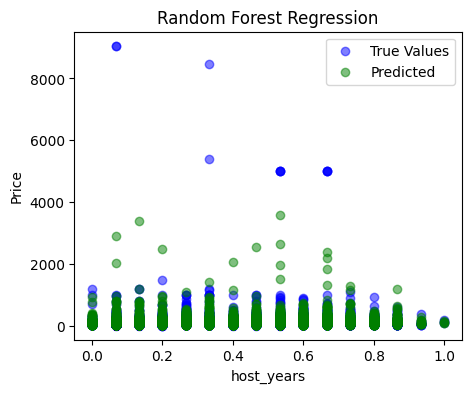

In [364]:
pred = cv_best_model.predict(X_test)
variable_of_interest = 'host_years'

fig, ax = plt.subplots(figsize=(5,4))

ax.scatter(X_test[variable_of_interest].values, y_test, color='blue', alpha=.5)
ax.scatter(X_test[variable_of_interest].values, pred, color='green', alpha=.5)
ax.set_title('Random Forest Regression')
ax.set_xlabel(variable_of_interest)
ax.set_ylabel('Price')
ax.legend(["True Values", "Predicted"])
plt.show()

## Gradient Boosting Regressor

### Baseline

In [ ]:
# Get baseline
base_gradboost = HistGradientBoostingRegressor(random_state=42)
base_gradboost.fit(X_train, y_train)

# Save model
joblib.dump(base_gradboost, 'models/base_gradboost_model.pkl', compress=True)

In [366]:
# Load model
base_model = joblib.load('models/base_gradboost_model.pkl')

# Print results
evaluate(base_gradboost, X_test, y_test)

-----Model Performance-----
Mean Absolute Error (MAE): 60.01
Mean Squared Error (MSE): 56261.69
Root Mean Squared Error (RMSE): 237.2
Mean Absolute Percentage Error (MAPE): 59.28
Accuracy: 40.72


### Hyperparameter Tuning

In [ ]:
# Instantiate model
gradboost = HistGradientBoostingRegressor(random_state=42)

# Dictionary of hyperparameters
param_grid = {
    'learning_rate': [.1, .01],
    'max_iter': [1000, 1500],
    'min_samples_leaf': [15, 20],
    'max_depth': [None, 10, 20],
    'l2_regularization': [0.1, 0.001, 0.0001]
}

# Hyperparameter tuning, automatically does 5-fold cv
cv_gradboost = GridSearchCV(gradboost, param_grid, n_jobs=-1, verbose=5)
cv_gradboost.fit(X_train, y_train)

# Pickle model
joblib.dump(cv_gradboost, 'models/cv_gradboost.pkl', compress=True)
joblib.dump(cv_gradboost.best_estimator_, 'models/cv_gradboost_best_model.pkl')

### Final Results

In [368]:
cv_gradboost_best_model = joblib.load('models/cv_gradboost_best_model.pkl')
cv_gradboost = joblib.load('models/cv_gradboost.pkl')

evaluate(cv_gradboost_best_model, X_test, y_test)

-----Model Performance-----
Mean Absolute Error (MAE): 59.25
Mean Squared Error (MSE): 55590.07
Root Mean Squared Error (RMSE): 235.78
Mean Absolute Percentage Error (MAPE): 57.5
Accuracy: 42.5


The random forest regressor performs better. 